# Analyse ROMY Events

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_velocities import plot_velocities

## Configurations

The configuration contains the parameters for the analysis.
Here we load the data from the FDSN service.

In [3]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..", # output seed ID for sixdegrees stream
    'rot_seed': ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV"], #  Rotation sensor seed ID
    'tra_seed': ["GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "fdsn",  # "fdsn" | "sds" | "mseed_file"

    # FDSN service
    'fdsn_client_rot': "http://george",  # "IRIS",
    'fdsn_client_tra': "https://jane.geophysik.uni-muenchen.de",  # "IRIS",

    # rotate to ZNE
    'rotate_zne': True,

    # remove instrument response
    'tra_remove_response': True,
    'rot_remove_response': True,

    # rotation for ROMY components (special case.. not required for pre-processed data)
    'use_romy_zne': True,
    'keep_z': True, # keep Z component from horizontal ring laser

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [4]:
sd = sixdegrees(conf=config)

Get key information about the event

In [5]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [6]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching GR.FUR..BHZ data from FDSN
-> fetching GR.FUR..BHN data from FDSN
-> fetching GR.FUR..BHE data from FDSN
-> translation inventory requested: Inventory created at 2025-12-09T16:44:57.000000Z
	Created by: JANE WEB SERVICE: fdsnws-station | Jane version: 0.0.0+archive
		    https://jane.geophysik.uni-muenchen.de/fdsnws/station/1/query?start...
	Sending institution: Jane (Jane)
	Contains:
		Networks (1):
			GR
		Stations (1):
			GR.FUR (Fuerstenfeldbruck, Bavaria, GR-Net)
		Channels (12):
			GR.FUR..BHZ, GR.FUR..BHN, GR.FUR..BHE, GR.FUR..HHZ, GR.FUR..HHN, 
			GR.FUR..HHE, GR.FUR..LHZ, GR.FUR..LHN, GR.FUR..LHE, GR.FUR..VHZ, 
			GR.FUR..VHN, GR.FUR..VHE
-> removing response: ACC
-> rotating translational data ZNE to ZNE
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHE | 2023-09-08T22:12:58.989999Z - 2023

Ensure that all traces of stream have the same sample size

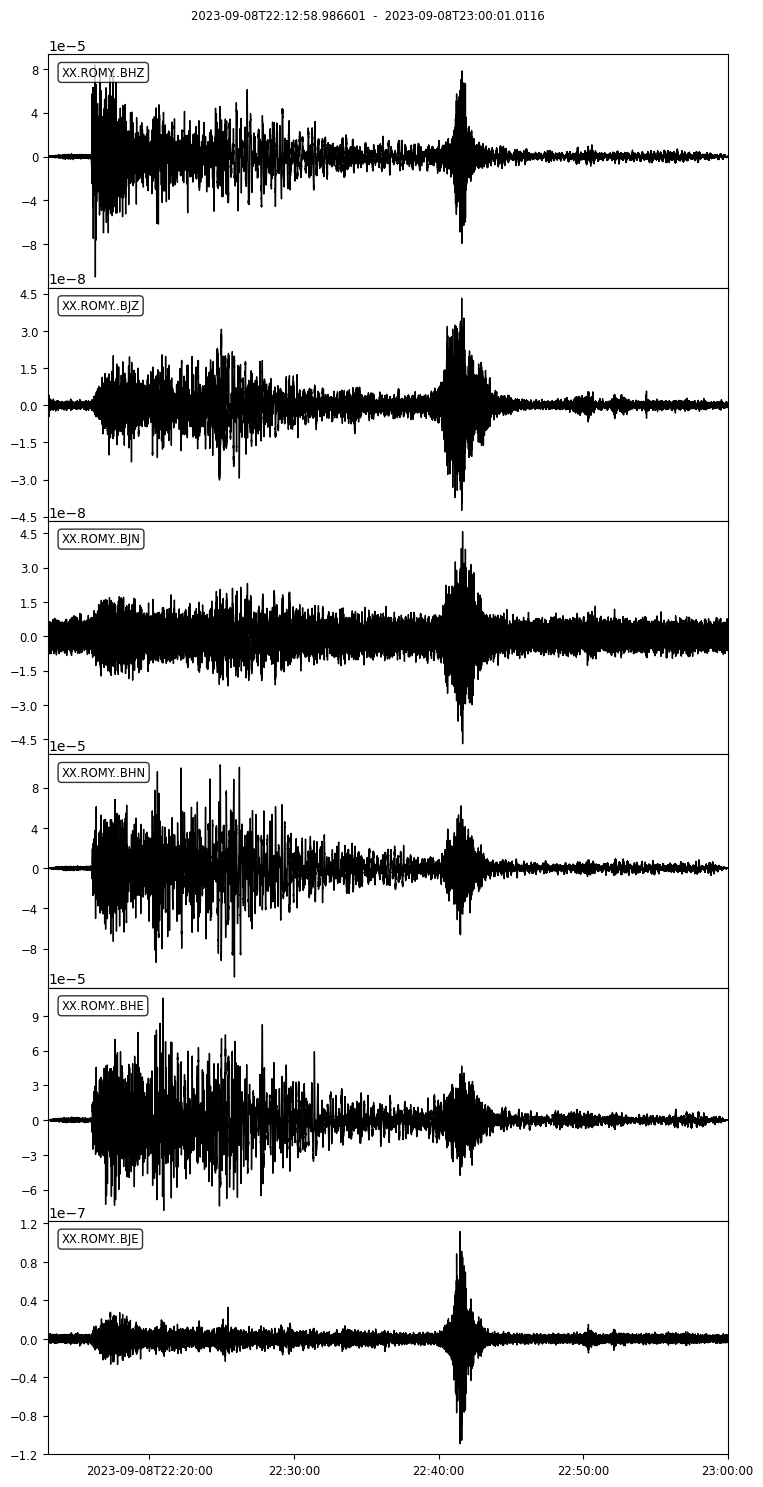

In [7]:
sd.st.plot(equal_scale=False);

In [8]:
# ensure all traces have the same sample size
sd.trim_stream(set_common=True)

# trim data to main event
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)

### Write data to file or SDS system

In [9]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [10]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [11]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


let's compare the waveforms of the rotation (red) and translational (black) components 

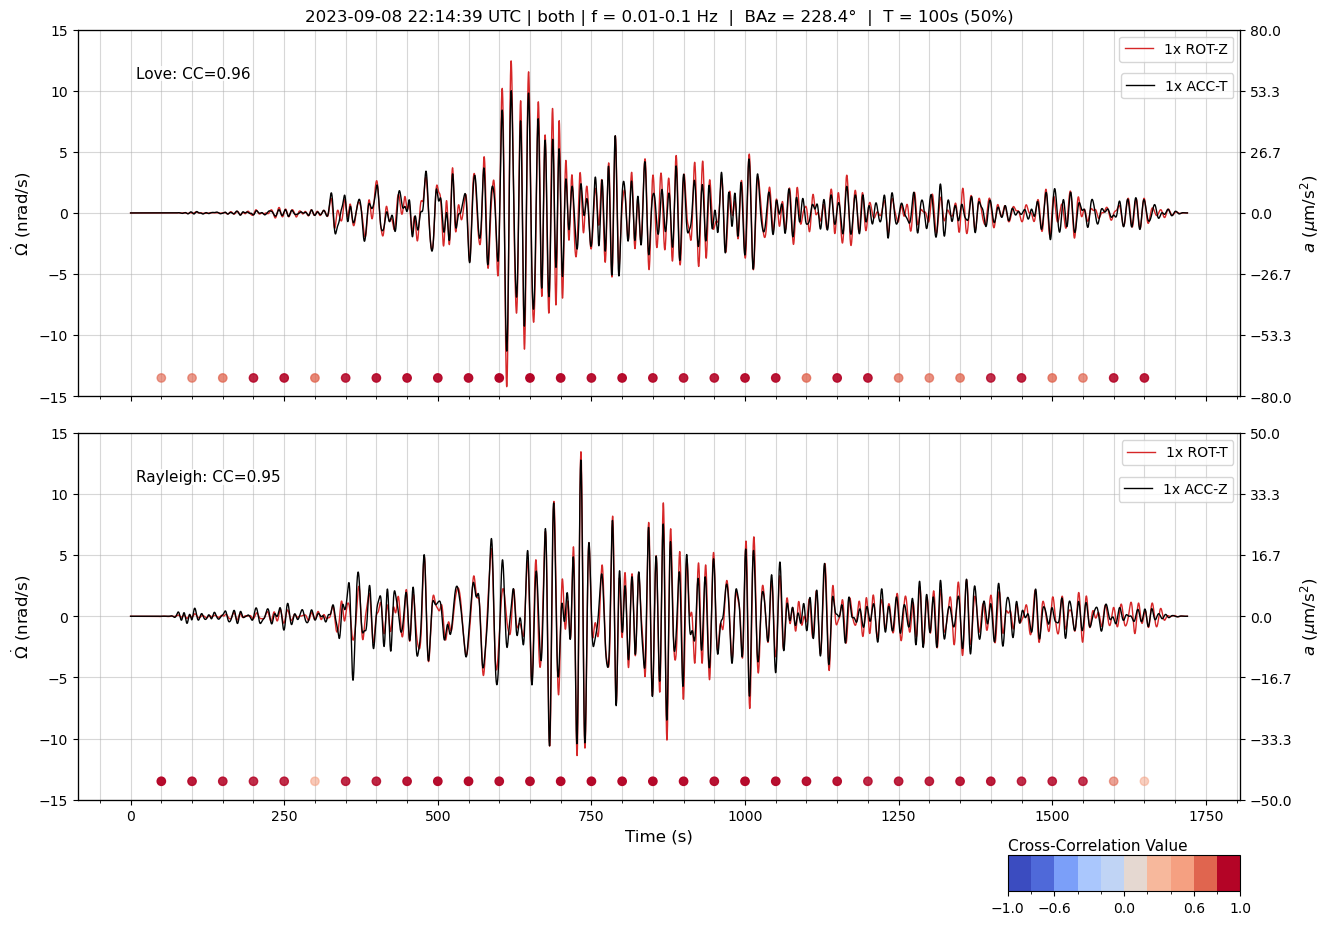

In [12]:
fig = plot_waveform_cc(
    rot0=sd.get_stream("rotation").copy(),
    acc0=sd.get_stream("translation").copy(),
    baz=ev['backazimuth'],
    twin_sec=100,
    twin_overlap=0.5,
    wave_type="both",
    fmin=sd.fmin,
    fmax=sd.fmax
)

### Compute Spectra

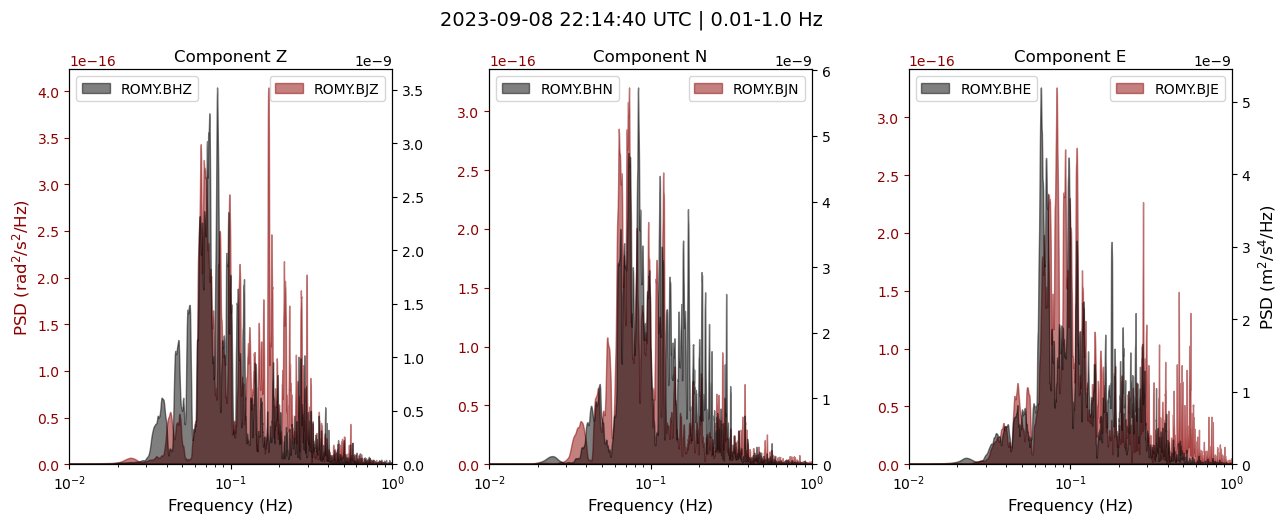

In [30]:
fig = sd.plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation", raw=True), 
    acc=sd.get_stream("translation", raw=True),
    fmin=0.01, fmax=1.0,
    ylog=False, xlog=True, fill=True
)

### Backazimuth Estimate

baz_max = 238, baz_std = 24


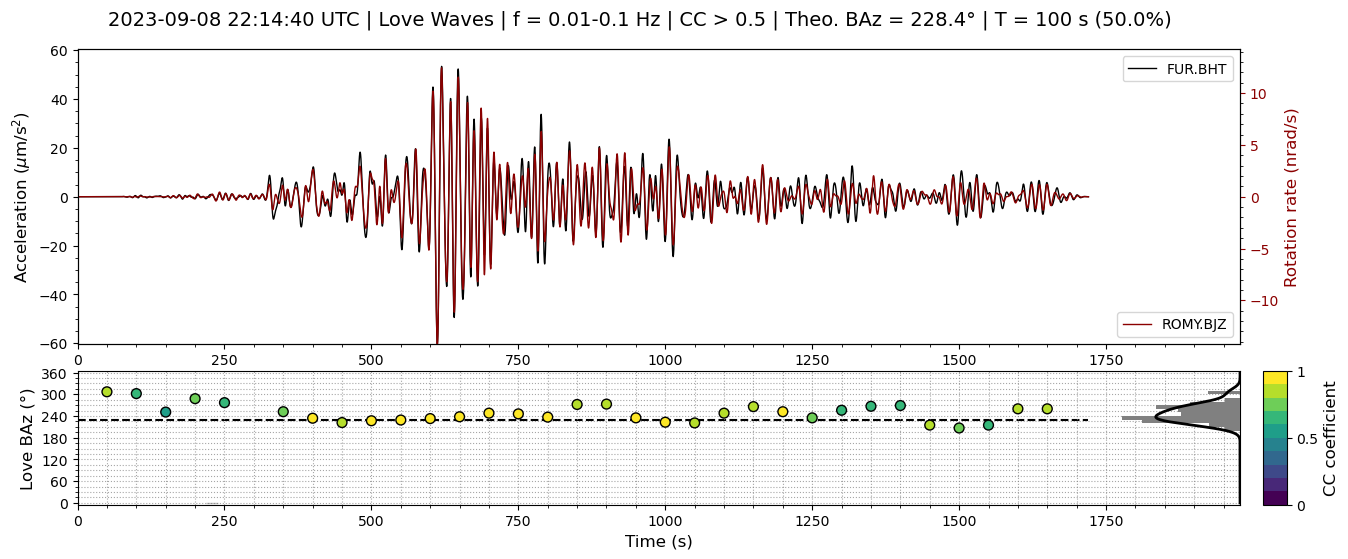

In [25]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)

baz_max = 230, baz_std = 10


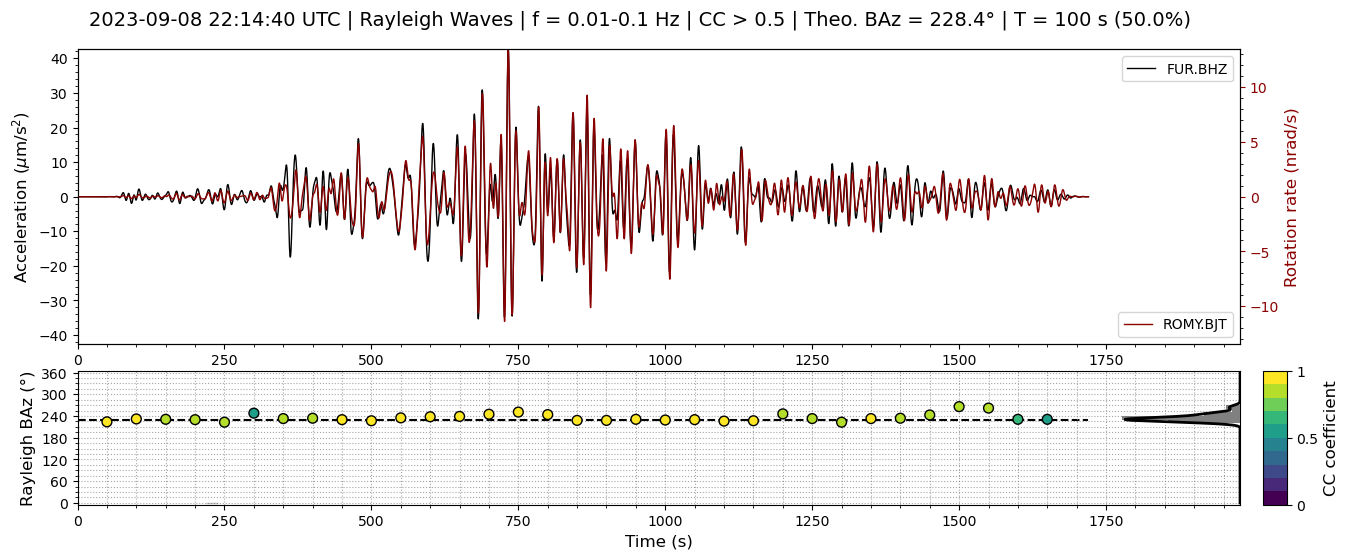

In [26]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)

# # Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)

Using precomputed love backazimuth results

Estimated BAZ Love = 238° (CC ≥ 0.1)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 227° (CC ≥ 0.1)
Using precomputed tangent backazimuth results

Estimated BAZ Tangent = 232° (CC ≥ 0.1)


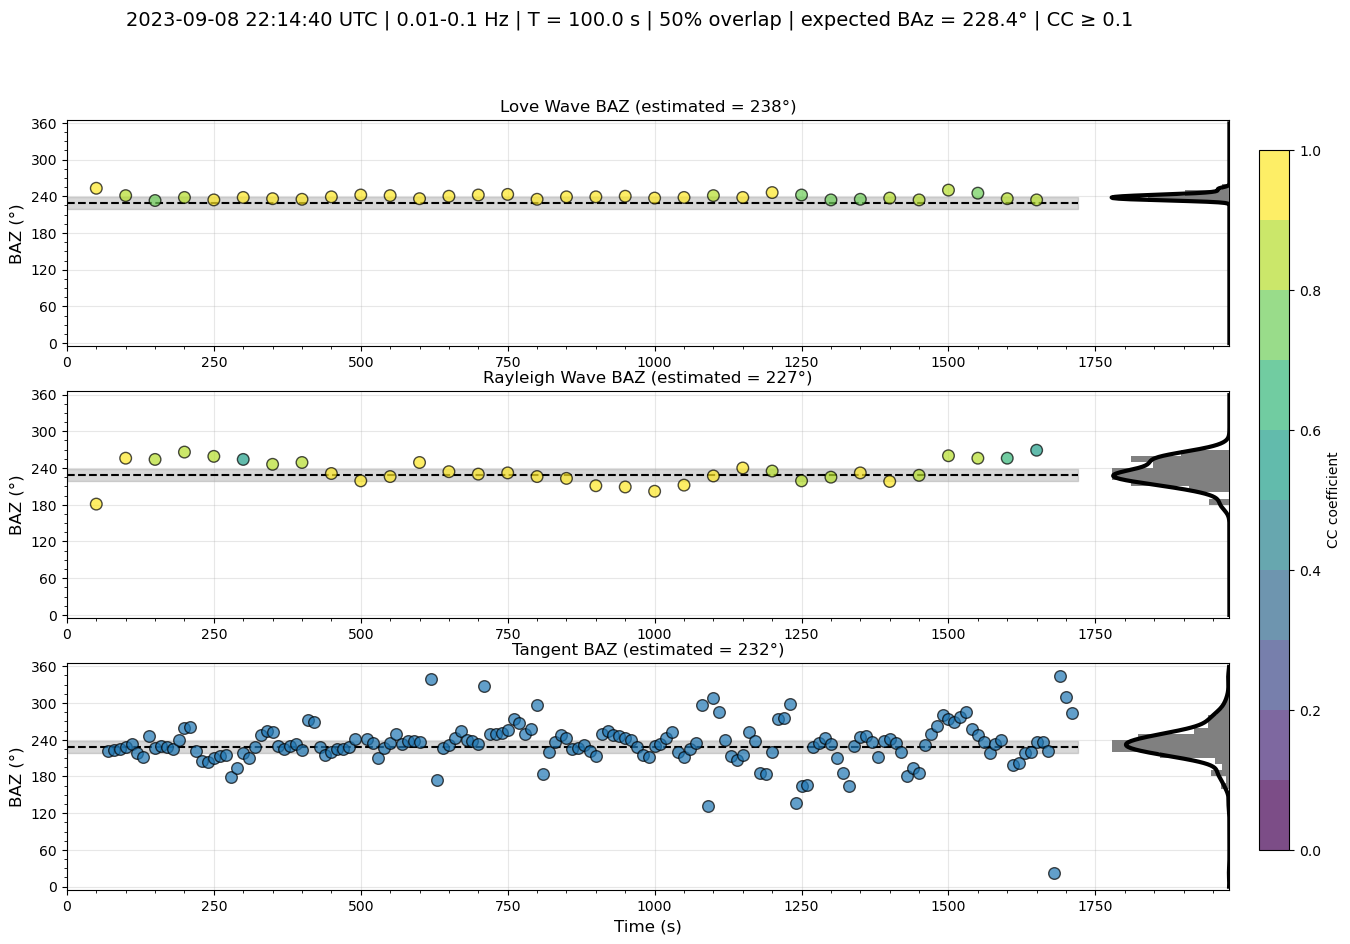

In [27]:
fig, results = sd.compare_backazimuth_methods(
    Twin=100.0,
    Toverlap=0.5,
    cc_threshold=0.1,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

In [28]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=100.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=100.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

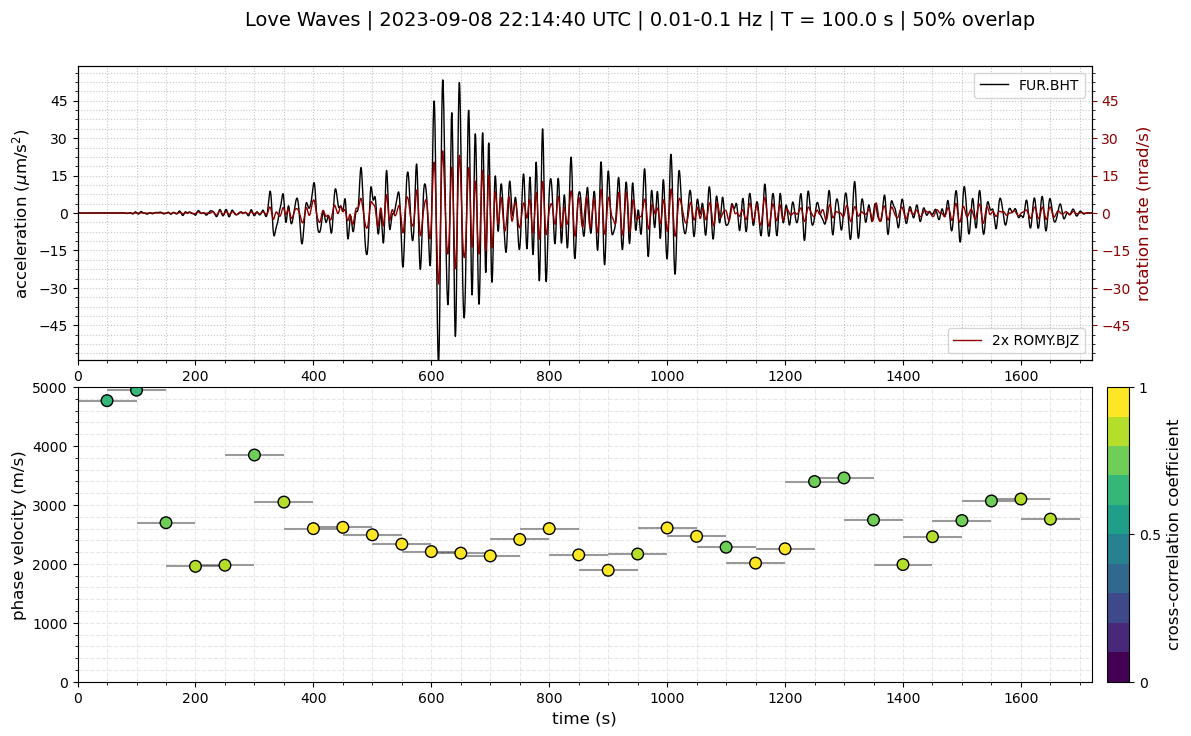

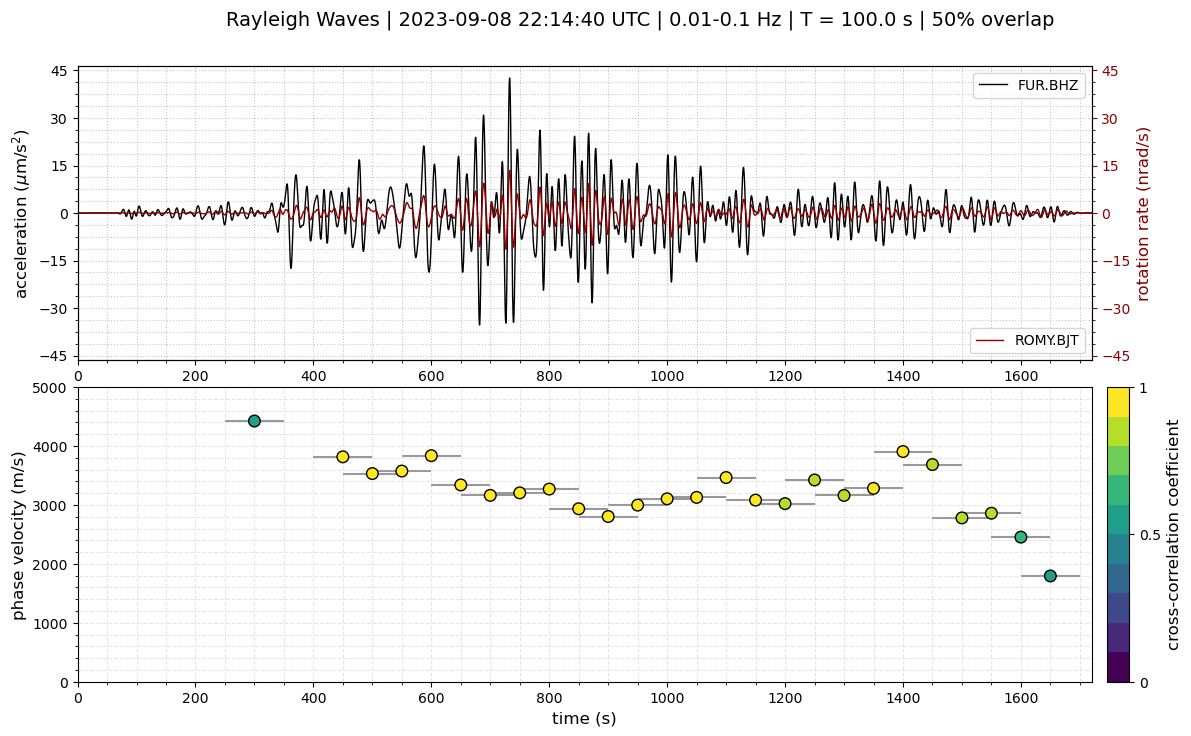

In [29]:
# Plot results
fig = plot_velocities(sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

## More Experimental

Here we estimate the velocities in time windows rather than assuming a constant backazimuth.

In [ ]:
love_velocities_win = sd.compute_velocities_in_windows(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    adjusted_baz=True,
)

In [ ]:
fig = sd.plot_velocities_win(
    results_velocities=love_velocities_win,
    cc_threshold=0.75,  # Only show results with CC >= 0.75
    baz_theo=ev['backazimuth'],     # Add reference
)

### Compare RANSAC and ODR

Here we compare the RANSAC and ODR methods for estimating the velocities.

In [ ]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [ ]:
fig = sd.plot_velocity_method_comparison(rayleigh_velocities_ransac,
                                         rayleigh_velocities_odr)